# Graph cut idea demo

In [1]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

## Generate a simple dataset with smooth convex border

In [3]:
G = NSWGraph()

N = 2000
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p) > 0.8 else 0
    values.append((p, cls))

        
G.build_navigable_graph(values, attempts=10)

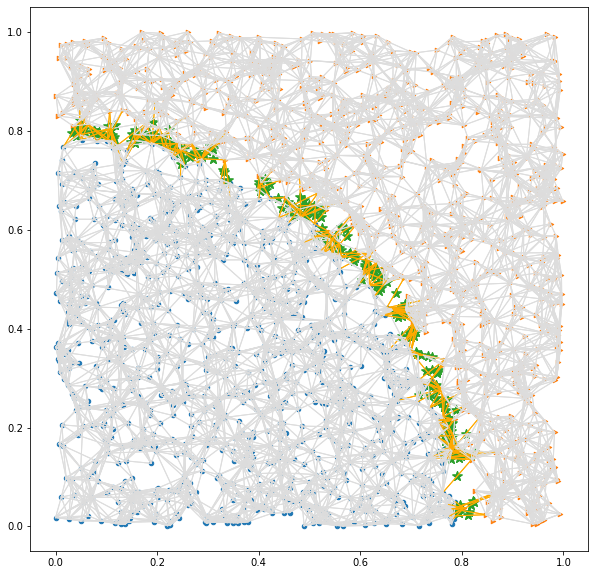

In [4]:
G.plot(.1)

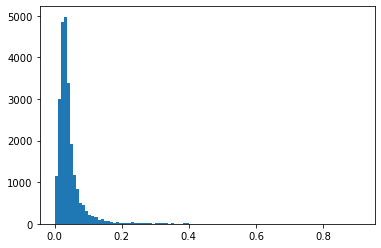

In [5]:
edges = [G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value) for e in G.get_edges()]
plt.hist(edges, bins=100)
plt.show()

## Lognorm? No

Params shape = 0.6792, loc = -0.0020, scale = 0.0355
E = 0.02408251474971652
Median 0.033


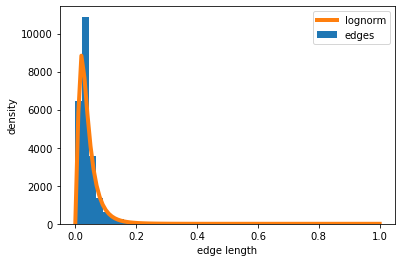

In [6]:
from  scipy.stats import lognorm, kstest
shape, loc, scale = lognorm.fit(edges)
print(f"Params shape = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")
expected_value = shape * scale
print("E =", expected_value) # edge length
median = lognorm.median(shape, loc, scale)
print(f"Median {median:.3f}")
plt.xlabel("edge length")
plt.ylabel("density")
plt.hist(edges, bins=40, label="edges")
x = np.linspace(0, 1, 101)
L = [lognorm.pdf(v, shape, loc, scale) * sum(edges) / 2.5 for v in x]
plt.plot(x, L, linewidth=4, label="lognorm")
plt.legend()
plt.show()

We expect `statistics` close to 0, and `p-value` close to 1 to be able not to reject Null-hypothesis (data comes from lognorm distribuition).

In [7]:
from scipy.stats import chisquare

samples = [lognorm.rvs(shape, loc, scale) for _ in range(10000)]
sample_bins, e = np.histogram(samples, range=(0.001, 1), bins=20)
edges_bins, e = np.histogram(edges, range=(0.001, 1), bins=20)
kstest(samples, "lognorm", lognorm.fit(samples))
print(chisquare(sample_bins / sum(sample_bins), edges_bins / sum(edges_bins)))

Power_divergenceResult(statistic=nan, pvalue=nan)


C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


We want the probability of rejecting a true null hypothesis to be $\alpha$ (e.g. high).
We reject when the observed `p-value` < $\alpha$.

In [114]:
# https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.kstest.html
kstest(edges, "lognorm", lognorm.fit(edges))

KstestResult(statistic=0.05590332336264214, pvalue=1.6078431355281151e-65)

Thus, this is definitely not lognormal with `p-value` << any.

# Fisher's? No

In [119]:
from scipy.stats import f as fisher

dfn, dfd, loc, scale = fisher.fit(edges)
myfisher_pdf = lambda x: fisher.pdf((x - loc) / scale, dfn, dfd)
myfisher_rvs = lambda: (fisher.rvs(dfn, dfd) + loc) * scale

print(dfn, dfd, loc, scale)
sample = [myfisher_rvs() for _ in range(10000)]
t = kstest(edges, sample)
print(t)

1.098408249845261 1.4409611078750248 0.00014944367407389457 0.033354244076282145
KstestResult(statistic=0.2830221971783955, pvalue=0.0)


# TODO: find a proper distribution. For now we will stick to gamma assuming this is changeable

In [149]:
distribution = gamma

In [134]:
params = distribution.fit(edges)
median = distribution.median(*params)
# half of the edges fall under this threshold!
print(f"Median: {median:.3f}")
G.plot(median)

Median: 6.512


ValueError: too many values to unpack (expected 2)

<Figure size 720x720 with 0 Axes>

# How dimensions influence distribution

Dimensions: 2
Params: (0.30696053392186073, 0.0006239078507715795, 0.125350582886975)


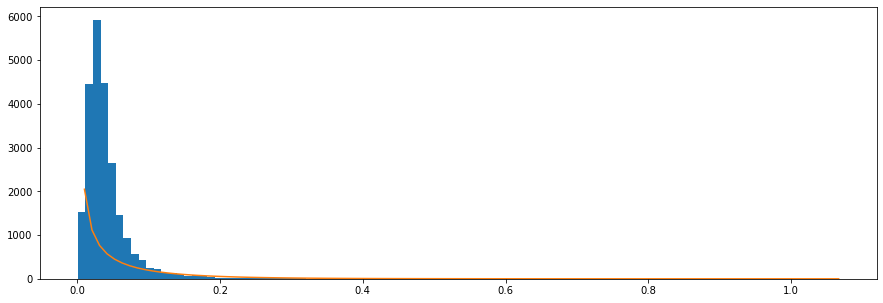

C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Power_divergenceResult(statistic=nan, pvalue=nan)
KstestResult(statistic=0.45198875116720194, pvalue=0.0)
Dimensions: 4
Params: (5.775640004713396, 0.011106277476424288, 0.03680998884557103)


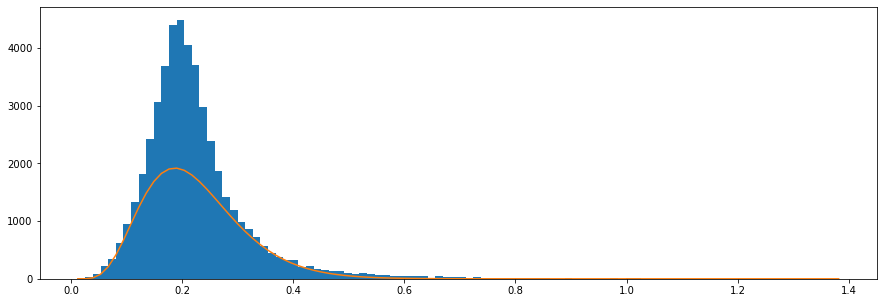

C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Power_divergenceResult(statistic=nan, pvalue=nan)
KstestResult(statistic=0.07254541518558699, pvalue=2.079637349343204e-219)
Dimensions: 8
Params: (12.759529782790853, 0.10768364665470251, 0.03861793089723625)


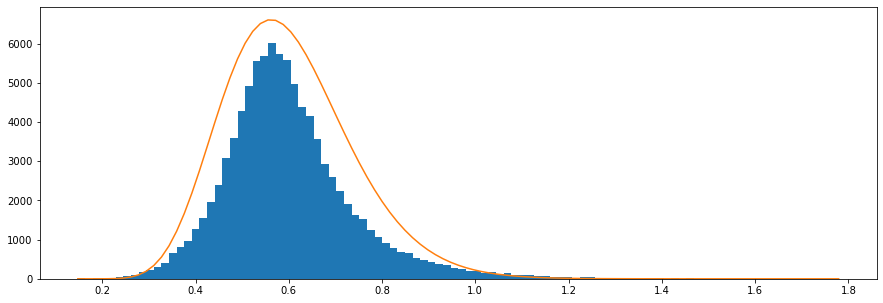

C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Power_divergenceResult(statistic=nan, pvalue=nan)
KstestResult(statistic=0.046566312562432155, pvalue=3.300089059310423e-180)
Dimensions: 16
Params: (23.542537546992875, 0.3772676636658161, 0.033215082544578806)


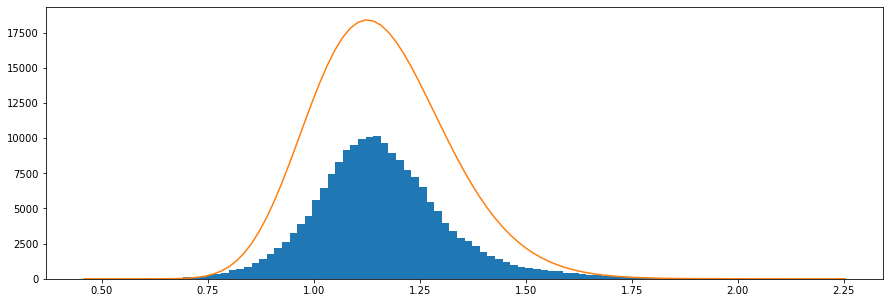

C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Power_divergenceResult(statistic=nan, pvalue=nan)
KstestResult(statistic=0.030785362087118018, pvalue=1.386992273010035e-156)
Dimensions: 32
Params: (40.70316668130112, 0.799388246692178, 0.027653512792112582)


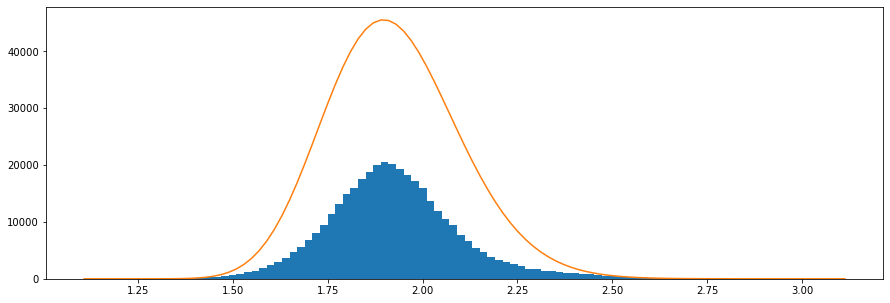

C:\anaconda\lib\site-packages\scipy\stats\stats.py:5996: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Power_divergenceResult(statistic=nan, pvalue=nan)
KstestResult(statistic=0.03402255639301255, pvalue=0.0)


KeyboardInterrupt: 

In [175]:
dims = [2, 4, 8, 16, 32, 64, 128, 256]
N = 2000

for dim in dims:
    G = NSWGraph()
    values = []
    for i in range(N):
        p = np.array([random.random() for _ in range(dim)])
        cls = 1 if vector_norm(p) > .79 * (dim / 2) ** .5 else 0
        values.append((p, cls))

    G.build_navigable_graph(values, attempts=10)
    
    print(f"Dimensions: {dim}")
    edges = [G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value) for e in G.get_edges()]
    params = distribution.fit(edges)
    print(f"Params: {params}")
    
    plt.figure(figsize=(15, 5))
    plt.hist(edges, bins=100)
    x = np.linspace(max(0.01, min(edges)), max(edges), 101)
    y = [distribution.pdf(i, *params) * sum(edges) * params[2] for i in x]
    plt.plot(x, y, label="gamma")
    plt.show()
    
    samples = [distribution.rvs(*params) for _ in range(10000)]
    sample_bins, e = np.histogram(samples, range=(0.01, 10), bins=20)
    edges_bins, e = np.histogram(edges, range=(0.01, 10), bins=20)
    print(chisquare(sample_bins / sum(sample_bins), edges_bins / sum(edges_bins)))
    
    print(kstest(edges, "gamma", args=params))    